# Basic Image classifcation using the FashionNist Sample Dataset

This is a simplified version of the example provided in the GluonCV AWS class on Coursera.

The original exercise normalized the data, did a two layer DNN and then enhanced the example using convolution and pooling layers.

This simplified version is a step wise process of doing the exercise with just the DNN, normalizing the input data is done in 
a second notebook.  Likewise using convolution and pooling is done in a third notebook.

The dataset api is [here](https://mxnet.apache.org/versions/1.7.0/api/python/docs/api/gluon/data/vision/datasets/index.html)
The source for the mxnet dataset api is [here](https://mxnet.apache.org/versions/1.5.0/_modules/mxnet/gluon/data/vision/datasets.html)


In [27]:
%%bash
pip install mxnet
pip install scikit-learn
pip install matplotlib
# progress bar
pip install tqdm

In [28]:
# python libs
import mxnet as mx
# mxnet NDarray shortcut
from mxnet import nd
# import gluon
from mxnet import gluon, init, nd, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from mxnet.gluon.data.vision import FashionMNIST
from mxnet.gluon.loss import SoftmaxCrossEntropyLoss
from sklearn.metrics import accuracy_score


# for plotting
from matplotlib import pyplot as plt

# for numpy arrays
import numpy as np

# file io
import os
import math # for pi

# script parameters
import sys

# for path operations
from pathlib import Path

# for progress bars
from tqdm import tqdm 

In [29]:
path = '../data/minc-2500'
train_path = os.path.join(path, 'train')
val_path = os.path.join(path, 'val')
test_path = os.path.join(path, 'test')

# Reference for mxnet approach to this problem
Using this code as a sample reference
https://github.com/rtp-aws/devpost_aws_disaster_response/blob/main/python/coursera_gluonCV_class/notebook/module_4_lab.ipynb

In [30]:
print(os.getenv('DATA_DIR'))

None


In [31]:
# ORIG M4_DATA = Path(os.getenv('DATA_DIR', '../../data'), 'module_4')
M4_DATA = Path(os.getenv('DATA_DIR', '../data'), 'module_4')
M4_IMAGES = Path(M4_DATA, 'images')
M4_MODELS = Path(M4_DATA, 'models')

# Data (and NDArray Operations)

We'll use the in-built dataset called FashionMNIST which is a variant of the commonly used MNIST dataset. It consists of 60,000 training images and 10,000 test images, and each image is a 28px by 28px greyscale image. We'll start by creating the dataset and visualize an example image.

In [32]:
test_dataset = FashionMNIST(train=False, root=M4_IMAGES).transform_first(transforms.ToTensor())

In [35]:
# encode the class names as strings
#                0             1          2           3        4       5         6        7          8      9       
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

The image label encoding is  4
the sample label human readable is  Coat


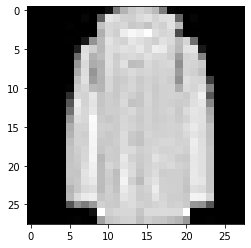

In [37]:
sample_idx = 123
sample_data, sample_label = test_dataset[sample_idx]
plt.imshow(sample_data[0].asnumpy(), cmap='gray')  # 0 for first and only channel (since greyscale).
print('The image label encoding is ', sample_label)
print('the sample label human readable is ', class_names[sample_label])


In [38]:
#print(sample_data)
print('the sample label is ', class_names[sample_label])
print(type(sample_data))
print(sample_data.shape)
print(sample_data[0,13,12])
print(type(sample_data[0,1,1].asscalar()))

the sample label is  Coat
<class 'mxnet.ndarray.ndarray.NDArray'>
(1, 28, 28)

[0.827451]
<NDArray 1 @cpu(0)>
<class 'numpy.float32'>


In [39]:
# Note the lazy transformation in the transform_first api call
test_dataloader = mx.gluon.data.DataLoader(test_dataset, shuffle=False, batch_size=1024)
for data, label in test_dataloader:
    break
print(type(data))
print(data.shape)

<class 'mxnet.ndarray.ndarray.NDArray'>
(1024, 1, 28, 28)


In [40]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [41]:
train_dataset = FashionMNIST(train=True, root=M4_IMAGES).transform_first(transform)
test_dataset = FashionMNIST(train=False, root=M4_IMAGES).transform_first(transform)
train_dataloader = mx.gluon.data.DataLoader(train_dataset, shuffle=True, batch_size=128)
test_dataloader = mx.gluon.data.DataLoader(train_dataset, shuffle=False, batch_size=128)

# 2) Metrics
In this section, you'll implement a function to test the prediction quality of networks. Using Accuracy as the evaluation metric, complete the following function that takes a network and a dataloader (with test data) and returns an MXNet Metric that has been updated with labels and predictions. We'll use this function in the next section, when we train classification networks.

**Hint**: You'll find classes in the mxnet.metric subpackage useful for this task.

In [15]:
def calculate_accuracy(network, dataloader):
    """
    Calculates accuracy of the network on the data given by the dataloader.
    
    :param network: network to be tested
    :type network: mx.gluon.Block
    :param dataloader: dataloader for test data
    :type dataloader: mx.gluon.data.DataLoader
    
    :return: updated metric
    :rtype: mx.metric.EvalMetric
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    accuracy = mx.metric.Accuracy()
    # tdqm is a progress bar library?
    for data, labels in tqdm(dataloader):
        preds = network(data)
        # YOUR CODE HERE
        #raise NotImplementedError()
        # print("labels is {}     preds are {}" . format(labels, preds))
        accuracy.update(labels,preds)
        
    return accuracy

## explanation of mx.gluon.nn.Dense() api
Docs are [here](https://mxnet.apache.org/versions/1.6/api/python/docs/api/gluon/nn/index.html#mxnet.gluon.nn.Dense)

This is a simple  single layer DNN of 28x28=768 pixel values and 10 outputs corresponding to the different image label classifications.

In [43]:
# this is the DNN
test_network = mx.gluon.nn.Dense(units=10)

# setup the DNN
test_network.initialize()

# train and evaludate the DNN?
metric = calculate_accuracy(test_network, test_dataloader)
print(metric.get())
print(test_network)
isinstance(metric, mx.metric.EvalMetric)
assert metric.name == 'accuracy'
assert metric.num_inst == 60000

100%|██████████| 469/469 [00:04<00:00, 102.16it/s]

('accuracy', 0.07595)
Dense(784 -> 10, linear)


# 3) Network
In the section, you'll implement a couple of different image classification networks and train then on the FashionMNIST dataset. A train function is already provided in this assignment, because the focus will be on network construction.

* sgd is possibly 'simple gradient descent'  It shows up in the list shown [here](https://mxnet.apache.org/versions/1.6/api/python/docs/api/optimizer/index.html#)

In [18]:
def train(network, dataloader):
    softmax_cross_entropy = mx.gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = mx.gluon.Trainer(network.collect_params(), 'sgd', {'learning_rate': 0.1})
    for data, label in tqdm(dataloader):
        with mx.autograd.record():
            output = network(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

Your first model should be a sequential network, with 3 layers. You first layer should have 16 hidden units, the second should have 8 hidden units and the last layer should the correct number of output units for the classification task at hand. You should add ReLU activations on all hidden layers, but not the output layer. You should define network in the cell below.

Hint: You'll find classes in the mxnet.gluon.nn subpackage useful for this task.

In [19]:
# YOUR CODE HERE
#raise NotImplementedError()

network = mx.gluon.nn.Sequential()
network.add(
    mx.gluon.nn.Dense(16, activation = 'relu'), # this is layer 1
    mx.gluon.nn.Dense(8, activation = 'relu'), # this is layer 2
    mx.gluon.nn.Dense(10) # the output layer, corresponding to the 10 class labels, sneaker, sandal, etc.
)

In [20]:
assert isinstance(network, mx.gluon.nn.Sequential)
assert len(network) == 3
assert isinstance(network[0], mx.gluon.nn.Dense)
assert network[0].act.name.endswith('relu')
assert network[0].weight.shape[0] == 16
assert isinstance(network[1], mx.gluon.nn.Dense)
assert network[1].act.name.endswith('relu')
assert network[1].weight.shape[0] == 8
assert isinstance(network[2], mx.gluon.nn.Dense)
assert network[2].act is None
assert network[2].weight.shape[0] == 10

In [21]:
print(network)

Sequential(
  (0): Dense(None -> 16, Activation(relu))
  (1): Dense(None -> 8, Activation(relu))
  (2): Dense(None -> 10, linear)
)


With your network now defined, you should initialize its parameters using the Xavier method in the cell below.

**Hint**: You'll find classes in the mxnet.init subpackage useful for this task.

In [22]:
# Use this guide
# https://mxnet.apache.org/api/python/docs/tutorials/packages/gluon/blocks/init.html

# YOUR CODE HERE
#raise NotImplementedError()
initializer = mx.init.Xavier()
network.initialize(initializer)


In [23]:
assert isinstance(initializer, mx.initializer.Xavier)

We'll now check the network summary and see that the network has 12786 trainable parameters.

In [24]:
network.summary(data)

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                           (1024, 1, 28, 28)               0
        Activation-1                    <Symbol dense1_relu_fwd>               0
        Activation-2                                  (1024, 16)               0
             Dense-3                                  (1024, 16)           12560
        Activation-4                    <Symbol dense2_relu_fwd>               0
        Activation-5                                   (1024, 8)               0
             Dense-6                                   (1024, 8)             136
             Dense-7                                  (1024, 10)              90
Parameters in forward computation graph, duplicate included
   Total params: 12786
   Trainable params: 12786
   Non-trainable params: 0
Shared params in forward computation graph: 0
Unique 

In [25]:
# Now we see the None for input is filled out with 768 pixel values for first layer
# compare with first print of the network
print(network)

Sequential(
  (0): Dense(784 -> 16, Activation(relu))
  (1): Dense(16 -> 8, Activation(relu))
  (2): Dense(8 -> 10, linear)
)


And use the calculate_accuracy function defined in the previous section to evaluate the performance of this architecture.

In [26]:
train(network, train_dataloader)
metric = calculate_accuracy(network, test_dataloader)
print(metric.get())

100%|██████████| 469/469 [00:04<00:00, 100.74it/s]

('accuracy', 0.7757333333333334)
